In [38]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import sklearn

from pandas import Series, DataFrame
from pylab import rcParams
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics 
from sklearn.metrics import classification_report
from tableone import TableOne

%matplotlib inline
rcParams['figure.figsize'] = 10, 8
sb.set_style('whitegrid')

import warnings
warnings.filterwarnings('ignore')

In [39]:
L4_Q4 = pd.read_csv("alldbs.csv", sep=',', encoding='ISO-8859-1')

In [40]:
print("Entre todas las bases de datos tenemos:")
print("Tenemos "+ str(len(L4_Q4))+" pacientes con "+str(len(list(L4_Q4.columns)))+" variables." )

Entre todas las bases de datos tenemos:
Tenemos 4861 pacientes con 46 variables.


# Preparacion datasets.
***

- Elimino intermedios
- Elimino columnas no importantes

In [41]:

L4_Q4_2 = L4_Q4.drop(['patient_id','sis_q', 'lactate', 'lactate_offset','hospdis_status','icu_los','hosp_los'
                            ,'sis','psychiatric','fluid_electrolyte'
                            ], axis=1)

variables = list(['peripheral_vascular','hypertension','diabetes','hypothyroidism','renal_failure','liver_disease','metastatic_cancer','rheumatoid_arthritis','coagulopathy','obesity','deficiency_anemias','chronic_pulmonary_disease','solid_cancer','chronic_neurologic_diseases','substance_abuse','heart_diseases'])
for var in variables:
    L4_Q4_2[var] = np.where(L4_Q4_2[var]==1,'Yes','No')
    



In [42]:
print("High y normal tenemos:")
print("Tenemos "+ str(len(L4_Q4_2))+" pacientes con "+str(len(list(L4_Q4_2.columns)))+" variables." )


High y normal tenemos:
Tenemos 4861 pacientes con 36 variables.


# Tabla división databases

Tabla entre databases: 


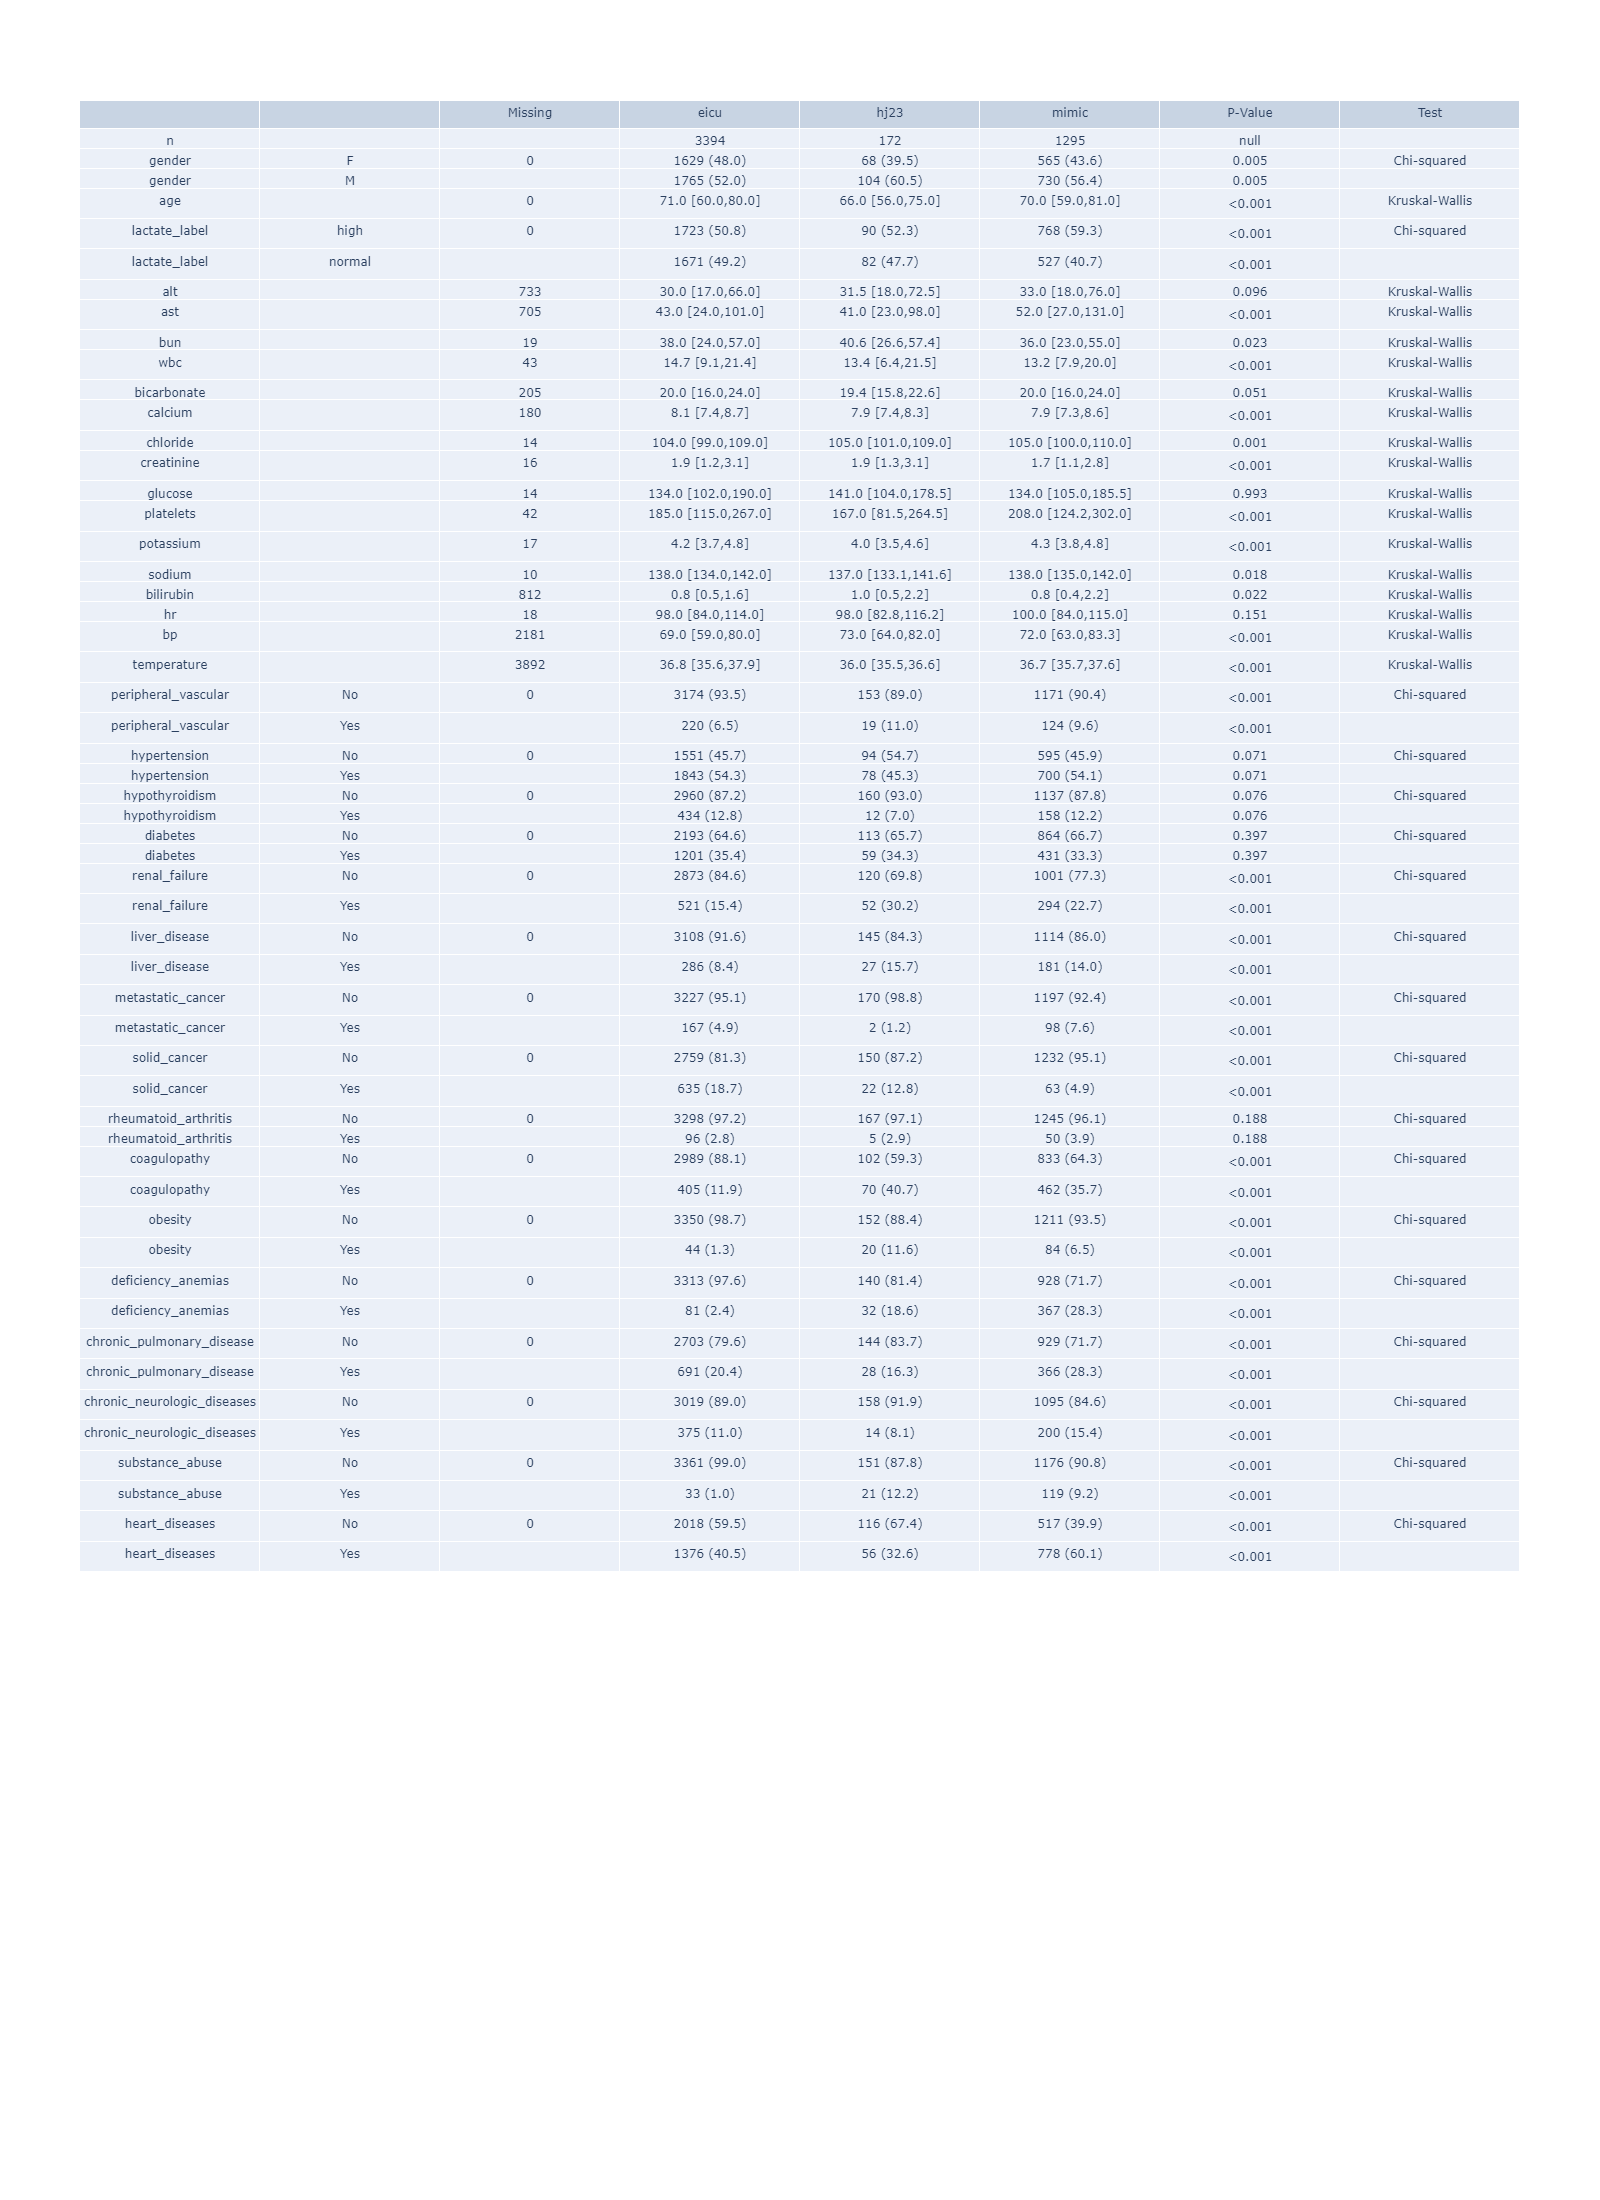

In [43]:
print("Tabla entre databases: ")
L4_Q4_2_db = L4_Q4_2.copy()


# TABLEONE para todo menos para ICU_LOS, IMV_d y VFD
# Divido las variables en categoricas y numéricas. 
categorical=list(L4_Q4_2_db.columns[L4_Q4_2_db.dtypes==np.object].drop('db'))
nonnormal=list(L4_Q4_2_db.columns[L4_Q4_2_db.dtypes!=np.object])

# Saco la tableone y formateo
tableOne=TableOne(L4_Q4_2_db, nonnormal=nonnormal,categorical=categorical,groupby=['db'], pval=True)
tableOne=tableOne.tableone.reset_index()
tableOne.columns = [col[0] if col[-1]=='' else col[-1] for col in tableOne.columns.values]
tableOne=tableOne.rename(columns={'level_0':'','level_1':' '})

tableOne.index= tableOne['']

# Elimino la columna de nulos porque no hay
# tableOne=tableOne.drop('Missing',axis=1)
tableOne['P-Value'] = np.where(tableOne['P-Value']=='',None,tableOne['P-Value'])
tableOne=tableOne.fillna(method='ffill')
# QuartilesScore=QuartilesScore.drop(columns={'Test'})

tableOne.to_csv('Tables/all_dbs.csv', sep=';', header = True, index=False)
# Ploteo la tabla
import plotly.graph_objects as go
fig = go.Figure(data=[go.Table(
    header=dict(values=list(tableOne.columns),
                align='center'),
    cells=dict(values=[tableOne[''],tableOne[' '],tableOne['Missing'],tableOne['eicu'],tableOne['hj23'],tableOne['mimic'],tableOne['P-Value'],tableOne['Test']],
               align='center'))
])
fig.update_layout(width=1600, height=2200)
fig.write_image("Tables/all_dbs.png")
figura=fig.to_image(format='png')
from IPython.display import Image
display(Image(figura))


- Divido en databases

In [44]:
hj23 = L4_Q4_2[L4_Q4_2['db']=='hj23']
hj23 = hj23.reset_index(drop=True)
hj23 = hj23.drop('db', axis=1)


In [45]:
print("En hj23 tenemos: ")
print("Tenemos "+ str(len(hj23))+" pacientes con "+str(len(list(hj23.columns)))+" variables." )


En hj23 tenemos: 
Tenemos 172 pacientes con 35 variables.


# Detección de nulos e imputación.
***
**Hay que hacerlo para las 3 icus**

- Empiezo por hj23.

In [46]:
# Creo un dataframe donde tengo las variables y el número de nulos de cada variable y los ordeno.
Nulos_hj23=pd.DataFrame(hj23.isnull().sum()).rename(columns={0:'Nulos'}).sort_values(by='Nulos',ascending=False)
# Calculo el porcentaje de nulos
Nulos_hj23['PorcentajeNulos'] = Nulos_hj23['Nulos']/len(hj23)

print(Nulos_hj23.loc[Nulos_hj23['PorcentajeNulos']>0])

# Elimino las variables que tienen un 50% de nulos
DeleteNulos=list(Nulos_hj23.loc[Nulos_hj23['PorcentajeNulos']>0.5].index)
hj23=hj23.drop(DeleteNulos, axis=1)

print("Voy a eliminar")
print(DeleteNulos)

#Muestro las dimensiones del nuevo dataframe
print("Tenemos "+ str(len(hj23))+" pacientes con "+str(len(list(hj23.columns)))+" variables." )






           Nulos  PorcentajeNulos
calcium      120         0.697674
bilirubin     31         0.180233
alt           24         0.139535
ast           23         0.133721
bun            7         0.040698
glucose        1         0.005814
Voy a eliminar
['calcium']
Tenemos 172 pacientes con 34 variables.


In [47]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# IteraiveImputer es capaz de simular los resultados de mice de R. Multivariate Imputation by Chained Equations
# Para imputar cada valor utiliza solo las 10 variables más cercanas.
imp = IterativeImputer(max_iter=10, random_state=0,initial_strategy='median',n_nearest_features=20)

# Solo se pueden imputar las numericas, por eso se separan las variables
categorical=hj23[list(hj23.columns[hj23.dtypes==np.object])]
categorical['index']=categorical.index
numerical=hj23[list(hj23.columns[hj23.dtypes!=np.object])]
numerical['index']=numerical.index

# Imputamos las variables numericas
numerical_imputed=imp.fit_transform(numerical)
numerical_imputed=pd.DataFrame(numerical_imputed, columns=numerical.columns)

# Unimos todas las variables
hj23=pd.merge(numerical_imputed,categorical, on=['index'],how='left')
hj23=hj23.drop('index',axis=1)


# Estandarización de los datos.
***

Podemos usar StandardScaler -> Media 0, desviación 1. A diferencias de creencias, no convierte la variable a una distribución normal.  
Podemos usar MinMaxScaler -> Valores entre 0 y 1. 

In [48]:
from sklearn.preprocessing import StandardScaler 
sc_hj23 = StandardScaler() 


hj23_no_std = hj23.copy()



# hj23
categorical=hj23[list(hj23.columns[hj23.dtypes==np.object])]
categorical['index']=categorical.index
numerical=hj23[list(hj23.columns[hj23.dtypes!=np.object])]

# Estandarizacion de las variables numericas
numerical_std=sc_hj23.fit_transform(numerical)  
numerical_std=pd.DataFrame(numerical_std, columns=numerical.columns)
numerical_std['index']=numerical_std.index

# Unimos todas las variables
hj23=pd.merge(numerical_std,categorical, on=['index'],how='left')
hj23=hj23.drop('index',axis=1)



# Test de colinealidad.
***
Buscamos la colinealidad con un heatmap. 
La buscamos tanto en cada una de las bases de datos como en la conjunta.

- hj23


--------------------------
Colinealidad Inicial hj23


<AxesSubplot:>

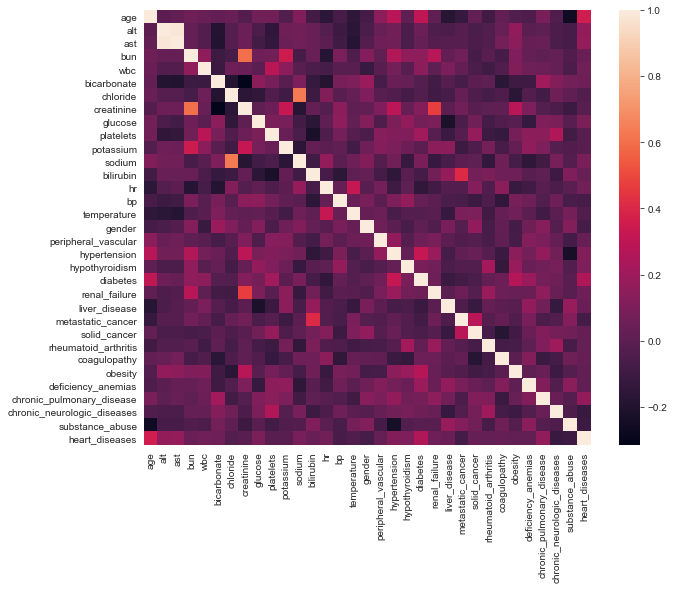

In [49]:
print("--------------------------")

print("Colinealidad Inicial hj23")

# %matplotlib inline
rcParams['figure.figsize'] = 10, 8
sb.set_style('whitegrid')

hj23_col = hj23.copy()

from sklearn import preprocessing
categorical=hj23_col[list(hj23_col.columns[hj23_col.dtypes==np.object])]
categorical=categorical.drop(['lactate_label'],axis=1)
for col in categorical:
    hj23_col[col] = preprocessing.LabelEncoder().fit_transform(hj23_col[col])
    
hj23_col = hj23_col.drop('lactate_label',axis=1)
                                                                                 
sb.heatmap(hj23_col.corr())


In [50]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = [variance_inflation_factor(hj23_col.values, hj23_col.columns.get_loc(var)) for var in hj23_col.columns]
print(pd.Series(vif,index=hj23_col.columns))


age                             1.607356
alt                            37.129407
ast                            36.811826
bun                             2.077769
wbc                             1.294147
bicarbonate                     2.079450
chloride                        2.450294
creatinine                      2.744990
glucose                         1.331295
platelets                       1.514192
potassium                       1.455855
sodium                          2.374412
bilirubin                       1.514561
hr                              1.670719
bp                              1.246528
temperature                     1.379541
gender                          2.652449
peripheral_vascular             1.340010
hypertension                    2.392237
hypothyroidism                  1.406262
diabetes                        2.457400
renal_failure                   2.026228
liver_disease                   1.617007
metastatic_cancer               1.537517
solid_cancer    

Hay correlación ast/alt, y sodium/chloride. Solo algo importante ast/alt.

Elimino alt y chloride por su Variance Inflation Factor tienen. 

In [51]:
hj23 = hj23.drop(['alt'], axis=1)
hj23_col = hj23_col.drop(['alt'], axis=1)
hj23_no_std = hj23_no_std.drop(['alt'], axis=1)


Colinealidad Final hj23


<AxesSubplot:>

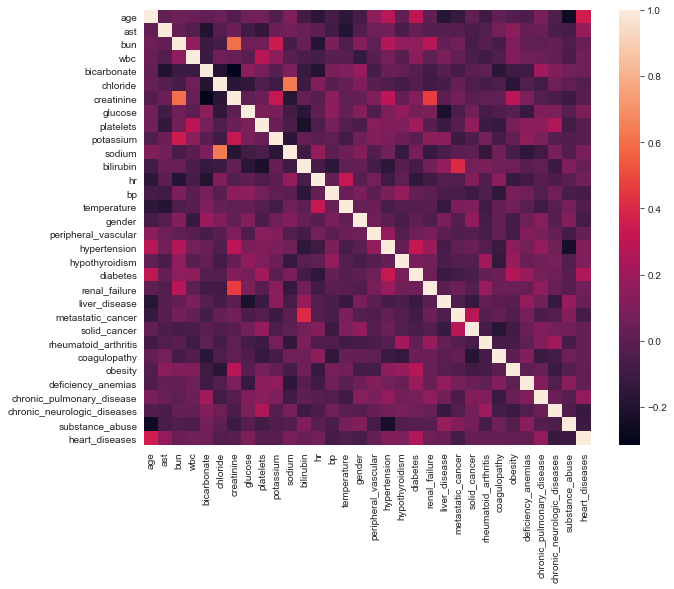

In [52]:
from sklearn import preprocessing
categorical=hj23_col[list(hj23_col.columns[hj23_col.dtypes==np.object])]
for col in categorical:
    hj23_col[col] = preprocessing.LabelEncoder().fit_transform(hj23_col[col])

print("Colinealidad Final hj23")
                                                                                 
sb.heatmap(hj23_col.corr())


In [53]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

## First var "MaxTvVol"
vif = [variance_inflation_factor(hj23_col.values, hj23_col.columns.get_loc(var)) for var in hj23_col.columns]
print(pd.Series(vif,index=hj23_col.columns))



age                            1.566546
ast                            1.261695
bun                            2.074557
wbc                            1.293422
bicarbonate                    2.076020
chloride                       2.450262
creatinine                     2.739616
glucose                        1.304262
platelets                      1.503251
potassium                      1.435427
sodium                         2.373721
bilirubin                      1.513822
hr                             1.631245
bp                             1.221458
temperature                    1.371163
gender                         2.649159
peripheral_vascular            1.339977
hypertension                   2.388807
hypothyroidism                 1.406260
diabetes                       2.401555
renal_failure                  2.024927
liver_disease                  1.605344
metastatic_cancer              1.537247
solid_cancer                   1.675500
rheumatoid_arthritis           1.377654


Vemos que todavía puede haber una pequeña correlación en creatinine/bun, pero ambas son muy bajas. 

In [54]:
# guardo los datasets

hj23_for_importants = hj23.copy()
hj23_for_importants_no_std = hj23_no_std.copy()




# Selección de variables.
***
Hago una TableOne y de aquí obtengo los P-Values, los tests utilizados son ambos no paramétricos.

- hj23

--------------------------
Table lactate hj23


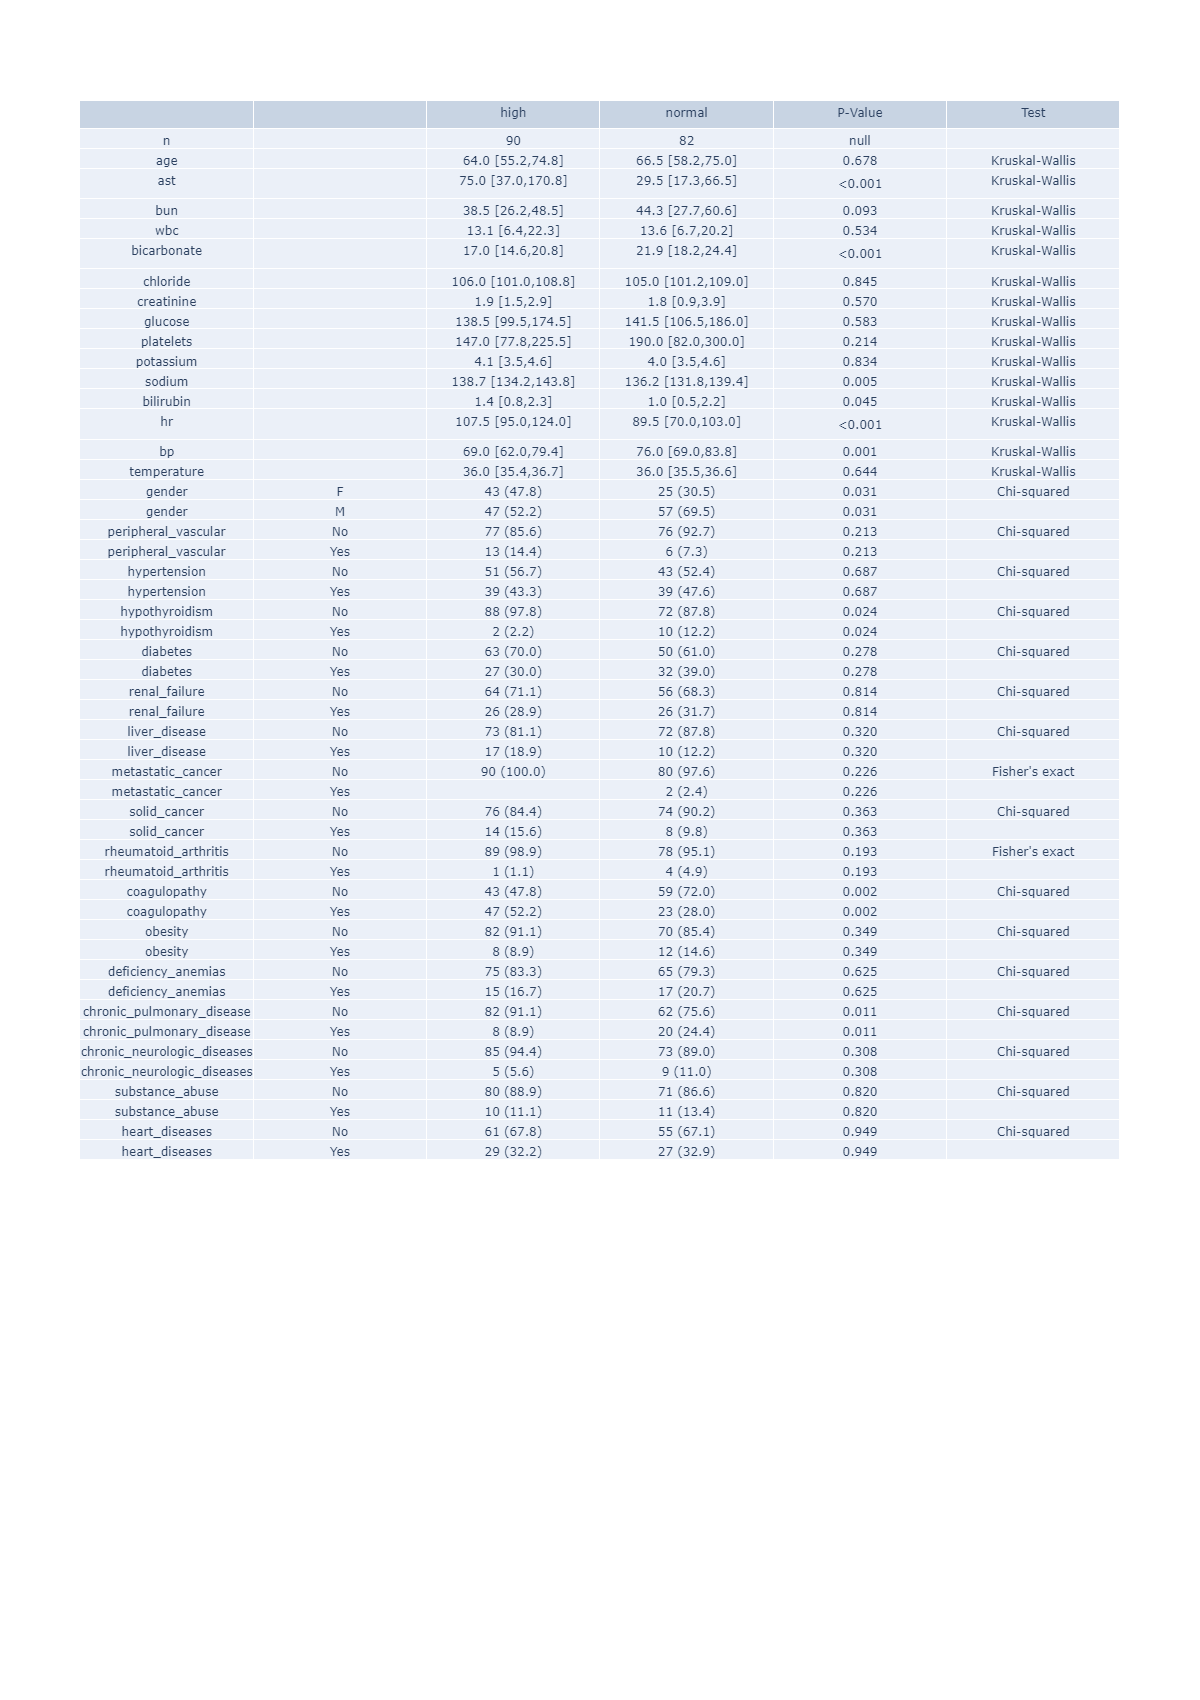

In [55]:
print("--------------------------")

print("Table lactate hj23")
hj23_sel = hj23_no_std.copy()


# TABLEONE para todo menos para ICU_LOS, IMV_d y VFD
# Divido las variables en categoricas y numéricas. 
categorical=list(hj23_sel.columns[hj23_sel.dtypes==np.object].drop('lactate_label'))
nonnormal=list(hj23_sel.columns[hj23_sel.dtypes!=np.object])

# Saco la tableone y formateo
tableOne=TableOne(hj23_sel, nonnormal=nonnormal,categorical=categorical,groupby=['lactate_label'], pval=True)
tableOne=tableOne.tableone.reset_index()
tableOne.columns = [col[0] if col[-1]=='' else col[-1] for col in tableOne.columns.values]
tableOne=tableOne.rename(columns={'level_0':'','level_1':' '})

tableOne.index= tableOne['']

# Elimino la columna de nulos porque no hay
tableOne=tableOne.drop('Missing',axis=1)
tableOne['P-Value'] = np.where(tableOne['P-Value']=='',None,tableOne['P-Value'])
tableOne=tableOne.fillna(method='ffill')
# QuartilesScore=QuartilesScore.drop(columns={'Test'})

tableOne.to_csv('Tables/hj23_lactate.csv', sep=';', header = True, index=False)
# Ploteo la tabla
import plotly.graph_objects as go
fig = go.Figure(data=[go.Table(
    header=dict(values=list(tableOne.columns),
                align='center'),
    cells=dict(values=[tableOne[''],tableOne[' '],tableOne['high'],tableOne['normal'],tableOne['P-Value'],tableOne['Test']],
               align='center'))
])

fig.update_layout(width=1200, height=1700)
fig.write_image("Tables/hj23_table.png")
figura=fig.to_image(format='png')
from IPython.display import Image
display(Image(figura))


# Logistic Regression with CV
***

- hj23

In [56]:
print("--------------------------")

print("Logistic Regression at hj23 for feature selection")

from mlxtend.feature_selection import SequentialFeatureSelector
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

feature_selector = SequentialFeatureSelector(LogisticRegression(solver='lbfgs'),
           k_features='best',
           scoring='roc_auc',
           forward=True,
           cv=5, n_jobs=-1)

hj23_lr = hj23.copy()
hj23_lr.to_csv('GeneratedFiles/Databases/hj23_lr.csv', sep=';', header = True, index=False)

hj23_lr['gender'] = np.where(hj23_lr['gender']=='M',1,0)
categorical=hj23_lr[list(hj23_lr.columns[hj23_lr.dtypes==np.object])].drop(['lactate_label'],axis=1)
for col in categorical:
    hj23_lr[col] = np.where(hj23_lr[col]=='Yes',1,0)
y = hj23_lr['lactate_label']
x= hj23_lr.drop(['lactate_label'],axis=1)
features = feature_selector.fit(np.array(x), y)


filtered_features= x.columns[list(features.k_feature_idx_)]
print("Selected features")
print(filtered_features)



--------------------------
Logistic Regression at hj23 for feature selection
Selected features
Index(['age', 'bun', 'bicarbonate', 'chloride', 'creatinine', 'potassium',
       'sodium', 'hr', 'bp', 'peripheral_vascular', 'hypertension',
       'hypothyroidism', 'liver_disease', 'solid_cancer',
       'rheumatoid_arthritis', 'deficiency_anemias',
       'chronic_pulmonary_disease'],
      dtype='object')


In [57]:
print(len(filtered_features))
print(features.k_score_)

17
0.9450980392156862


In [58]:

filtered_features=filtered_features.to_list()
filtered_features.append('lactate_label')

In [59]:
from sklearn.model_selection import cross_validate
hj23_lr = hj23.copy()

hj23_lr = hj23_lr[filtered_features]
hj23_lr_2 = hj23_lr.copy()
categorical=hj23_lr[list(hj23_lr.columns[hj23_lr.dtypes==np.object])].drop(['lactate_label'],axis=1)
for col in categorical:
    hj23_lr[col] = np.where(hj23_lr[col]=='Yes',1,0)

hj23_lr['lactate_label'] = np.where(hj23_lr['lactate_label'] == 'high',1,0)

lr = LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
y_lr = hj23_lr['lactate_label']
x_lr= hj23_lr.drop(['lactate_label'],axis=1)

cv_model = cross_validate(lr, x_lr, y_lr, cv=5, return_train_score=True, return_estimator=True, scoring = ['accuracy', 'recall', 'roc_auc'])
scores=pd.DataFrame(cv_model['test_accuracy'])
scores.columns=['score']
scores = scores.sort_values('score',ascending=False)
print("Scores of Cross Validation")
print(scores)

best_estimator = cv_model['estimator'][scores.iloc[0].name]

print('roc '+str(cv_model['test_roc_auc'][scores.iloc[0].name]))
print('recall '+str(cv_model['test_recall'][scores.iloc[0].name]))

Scores of Cross Validation
      score
0  0.942857
3  0.882353
4  0.882353
1  0.771429
2  0.764706
roc 0.9869281045751633
recall 0.8888888888888888


Importance of features for hj23 after CV


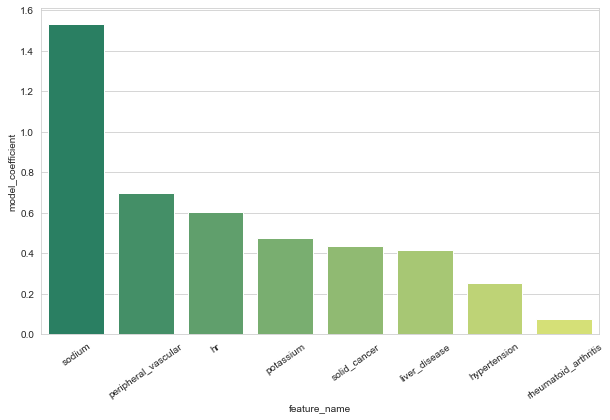

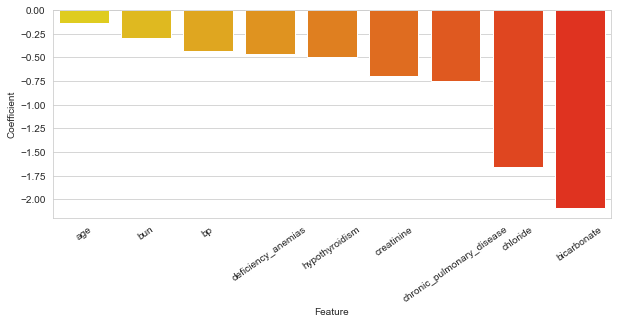

In [60]:
print("Importance of features for hj23 after CV") 
# Get the models coefficients (and top 5 and bottom 5)
logReg_coeff_lr_hj23 = pd.DataFrame({'feature_name': x_lr.columns.values, 'model_coefficient': best_estimator.coef_.transpose().flatten()})
logReg_coeff_lr_hj23 = logReg_coeff_lr_hj23.sort_values('model_coefficient',ascending=False)
logReg_coeff_top = logReg_coeff_lr_hj23.head(sum(logReg_coeff_lr_hj23['model_coefficient']>0))
logReg_coeff_bottom = logReg_coeff_lr_hj23.tail(sum(logReg_coeff_lr_hj23['model_coefficient']<0))


# Plot top 5 coefficients
plt.figure().set_size_inches(10, 6)
fg3 = sb.barplot(x='feature_name', y='model_coefficient',data=logReg_coeff_top, palette="summer")
fg3.set_xticklabels(rotation=35, labels=logReg_coeff_top.feature_name)
# Plot bottom 5 coefficients
plt.figure().set_size_inches(10,6)
fg4 = sb.barplot(x='feature_name', y='model_coefficient',data=logReg_coeff_bottom, palette="autumn_r")
fg4.set_xticklabels(rotation=35, labels=logReg_coeff_bottom.feature_name)
plt.xlabel('Feature')
plt.ylabel('Coefficient')
plt.subplots_adjust(bottom=0.4)
# plt.savefig('figure_4.png')

In [61]:
print("Classification")

from sklearn import metrics
pred=best_estimator.predict(x_lr)
classes_lr=np.where(np.logical_and(pred==1,y_lr.values==1),'TP',
         np.where(np.logical_and(pred==1,y_lr.values==0),'FP',
                  np.where(np.logical_and(pred==0,y_lr.values==0), 'TN',
                           np.where(np.logical_and(pred==0,y_lr.values==1),'FN','MAL'))))
import scipy
print(scipy.stats.itemfreq(classes_lr))


Classification
[['FN' '10']
 ['FP' '8']
 ['TN' '74']
 ['TP' '80']]


In [62]:
logReg_coeff_lr_hj23.to_csv('GeneratedFiles/ImportantVariables/coef_lr_hj23.csv', sep=';', header = False, index=False)

# RandomForest with CV
***

- hj23

In [63]:
print("--------------------------")

print("Random Forest at hj23 for feature selection")

feature_selector = SequentialFeatureSelector(RandomForestClassifier(n_estimators=200, random_state=0,max_depth=10, n_jobs=-1),
           k_features='best',
           scoring='roc_auc',
           forward=True,
           cv=5, n_jobs=-1)

hj23_rf = hj23_no_std.copy()
hj23_rf_2 = hj23_rf.copy()
hj23_rf_2.to_csv('GeneratedFiles/Databases/hj23_rf.csv', sep=';', header = True, index=False)

hj23_rf_2['gender'] = np.where(hj23_rf_2['gender']=='M',1,0)

categorical=hj23_rf_2[list(hj23_rf_2.columns[hj23_rf_2.dtypes==np.object])].drop(['lactate_label'],axis=1)
for col in categorical:
    hj23_rf_2[col] = np.where(hj23_rf_2[col]=='Yes',1,0)
y = hj23_rf_2['lactate_label']
x= hj23_rf_2.drop(['lactate_label'],axis=1)
features = feature_selector.fit(np.array(x), y)


filtered_features= x.columns[list(features.k_feature_idx_)]
print("Selected Features")
print(filtered_features)


--------------------------
Random Forest at hj23 for feature selection
Selected Features
Index(['age', 'ast', 'bicarbonate', 'creatinine', 'sodium', 'hr', 'bp',
       'gender', 'peripheral_vascular', 'liver_disease', 'metastatic_cancer',
       'deficiency_anemias', 'chronic_pulmonary_disease'],
      dtype='object')


In [64]:
print(len(filtered_features))
print(features.k_score_)

13
0.8952614379084967


In [65]:

filtered_features=filtered_features.to_list()
filtered_features.append('lactate_label')

Score for CV
      score
2  0.882353
0  0.828571
1  0.771429
3  0.735294
4  0.705882
roc 0.9409722222222222
recall 0.8333333333333334


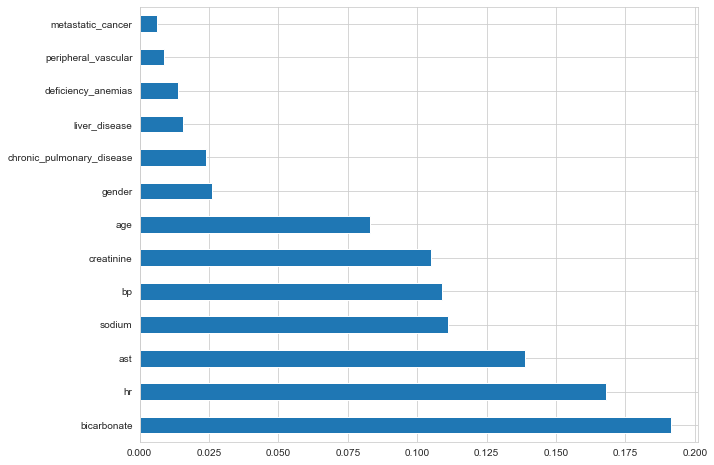

In [66]:
from sklearn.model_selection import cross_validate
hj23_rf_2 = hj23_rf.copy()

hj23_rf_2 = hj23_rf_2[filtered_features]

if 'gender' in filtered_features:
    hj23_rf_2['gender'] = np.where(hj23_rf_2['gender']=='M',1,0)
    
categorical=hj23_rf_2[list(hj23_rf_2.columns[hj23_rf_2.dtypes==np.object])].drop(['lactate_label'],axis=1)
for col in categorical:
    hj23_rf_2[col] = np.where(hj23_rf_2[col]=='Yes',1,0)

hj23_rf_2['lactate_label'] = np.where(hj23_rf_2['lactate_label'] == 'high',1,0)

rf = features.estimator
y_rf = hj23_rf_2['lactate_label']
x_rf= hj23_rf_2.drop(['lactate_label'],axis=1)


cv_model = cross_validate(rf, x_rf, y_rf, cv=5, return_train_score=True, return_estimator=True, scoring = ['accuracy', 'recall', 'roc_auc'])
scores=pd.DataFrame(cv_model['test_accuracy'])
scores.columns=['score']
scores = scores.sort_values('score',ascending=False)
print("Score for CV")
print(scores)

bestRF = cv_model['estimator'][scores.iloc[0].name]
plt.figure(103)
importances = pd.Series(bestRF.feature_importances_,x_rf.columns)
importances.nlargest(20).plot(kind='barh')

print('roc '+str(cv_model['test_roc_auc'][scores.iloc[0].name]))
print('recall '+str(cv_model['test_recall'][scores.iloc[0].name]))


In [67]:
for var in importances.index:
    if var in list(categorical.columns):
        high = sum(hj23_rf_2.loc[hj23_rf_2['lactate_label']==1][var] == 1)
        low = sum(hj23_rf_2.loc[hj23_rf_2['lactate_label']==0][var] == 1)
        if(high<=low):
            importances[var] = -importances[var]
    else:
        high = np.median(hj23_rf_2.loc[hj23_rf_2['lactate_label']==1][var])
        low = np.median(hj23_rf_2.loc[hj23_rf_2['lactate_label']==0][var])
        if(high<=low):
            importances[var] = -importances[var]

Importance of features for hj23 after CV


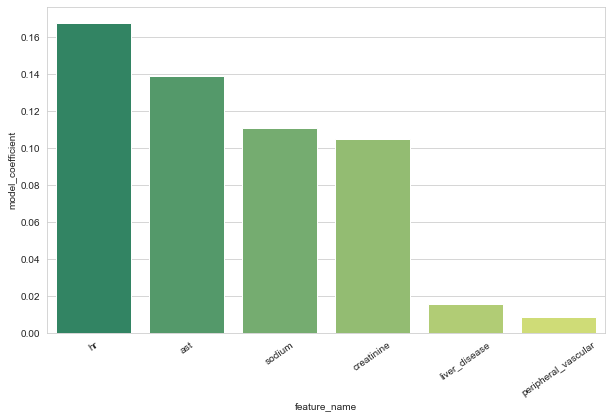

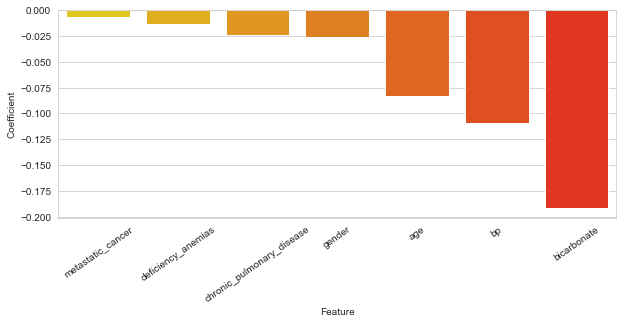

In [68]:
print("Importance of features for hj23 after CV") 
    
# Get the models coefficients (and top 5 and bottom 5)
logReg_coeff_rf_hj23 = pd.DataFrame({'feature_name': x_rf.columns.values, 'model_coefficient': importances})
logReg_coeff_rf_hj23 = logReg_coeff_rf_hj23.sort_values('model_coefficient',ascending=False)
logReg_coeff_top = logReg_coeff_rf_hj23.head(sum(logReg_coeff_rf_hj23['model_coefficient']>0))
logReg_coeff_bottom = logReg_coeff_rf_hj23.tail(sum(logReg_coeff_rf_hj23['model_coefficient']<0))


# Plot top 5 coefficients
plt.figure(100).set_size_inches(10, 6)
fg3 = sb.barplot(x='feature_name', y='model_coefficient',data=logReg_coeff_top, palette="summer")
fg3.set_xticklabels(rotation=35, labels=logReg_coeff_top.feature_name)
# Plot bottom 5 coefficients
plt.figure(101).set_size_inches(10,6)
fg4 = sb.barplot(x='feature_name', y='model_coefficient',data=logReg_coeff_bottom, palette="autumn_r")
fg4.set_xticklabels(rotation=35, labels=logReg_coeff_bottom.feature_name)
plt.xlabel('Feature')
plt.ylabel('Coefficient')
plt.subplots_adjust(bottom=0.4)
# plt.savefig('figure_4.png')

In [69]:
print("Classification")
from sklearn import metrics
pred=bestRF.predict(x_rf)
classes_rf=np.where(np.logical_and(pred==1,y_rf.values==1),'TP',
         np.where(np.logical_and(pred==1,y_rf.values==0),'FP',
                  np.where(np.logical_and(pred==0,y_rf.values==0), 'TN',
                           np.where(np.logical_and(pred==0,y_rf.values==1),'FN','MAL'))))
import scipy
print(scipy.stats.itemfreq(classes_rf))


Classification
[['FN' '3']
 ['FP' '1']
 ['TN' '81']
 ['TP' '87']]


In [70]:
logReg_coeff_rf_hj23.to_csv('GeneratedFiles/ImportantVariables/coef_rf_hj23.csv', sep=';', header = False, index=False)


# ORTHOGONAL PLS

In [71]:
print("--------------------------")

print("Orthogonal PLS at hj23 for feature selection")

hj23_pls=hj23.copy()
hj23_pls.to_csv('GeneratedFiles/Databases/hj23_pls.csv', sep=';', header = True, index=False)
hj23_pls['gender'] = np.where(hj23_pls['gender']=='M',1,0)
categorical=hj23_pls[list(hj23_pls.columns[hj23_pls.dtypes==np.object])].drop(['lactate_label'],axis=1)
for col in categorical:
    hj23_pls[col] = np.where(hj23_pls[col]=='Yes',1,0)

hj23_pls['lactate_label'] = np.where(hj23_pls['lactate_label'] == 'high',1,0)

y_lr = hj23_pls['lactate_label']
x_lr= hj23_pls.drop(['lactate_label'],axis=1)


# x_lr=x_lr.drop('classes', axis=1)
y_lr = np.array(y_lr, dtype=int)

--------------------------
Orthogonal PLS at hj23 for feature selection


In [72]:
import itertools
from sklearn.model_selection import KFold
from pyopls import OPLS
from sklearn.cross_decomposition import PLSCanonical, PLSRegression, CCA
from sklearn import metrics

def primeros_tres_pls():
    combinatoria= list(itertools.combinations(list(x_lr.columns),3))
    mejor_media = 0 
    for i in combinatoria: 
        actual = list()
        for var in i: 
            actual.append(var)
        x_pls = pd.DataFrame(x_lr[actual])
        kf = KFold(n_splits=5)
        roc_pls_componentes=list()
        for train_index, test_index in kf.split(hj23):
            X_train = x_pls.iloc[train_index]
            X_test = x_pls.iloc[test_index]
            y_train, y_test = y_lr[train_index], y_lr[test_index]
            opls = OPLS(2,scale=False)
            Z = opls.fit(X_train, y_train)
            X_train=X_train.astype(np.float64)
            Z_trans= Z.transform(X_train)
            pls2 = PLSRegression(1,scale=False)
            pls2.fit(Z_trans, y_train)
            X_test=X_test.astype(np.float64)
            Z_trans_test = Z.transform(X_test)
            predict=pls2.predict(Z_trans_test)
            predict_roc=np.where(predict>1,1,np.where(predict<0,0,predict))
            roc_pls_componentes.append(metrics.roc_auc_score(y_test,predict_roc))
        roc_pls_componentes.sort(reverse=True)
#         media_acc = roc_pls_componentes[0]
        media_acc = sum(roc_pls_componentes)/5
        if media_acc>mejor_media: 
            mejor_media = media_acc
            selected = actual
    return(mejor_media, selected)

In [73]:
from sklearn.model_selection import KFold
from pyopls import OPLS
from sklearn.cross_decomposition import PLSCanonical, PLSRegression, CCA
from sklearn import metrics

def busca_nueva(dataset,objetivo, media_actual, seleccionadas):
    lista_vars = list(dataset.columns)
    lista_vars=[ele for ele in lista_vars if ele not in selected] 
    mejor_media=media_actual
    mejor_var = ''
    for i in (lista_vars):
        selected.append(i)
        x_pls = pd.DataFrame(dataset[selected])
        kf = KFold(n_splits=5)
        roc_pls_componentes=list()
        for train_index, test_index in kf.split(hj23):
            X_train = x_pls.iloc[train_index]
            X_test = x_pls.iloc[test_index]
            y_train, y_test = objetivo[train_index], objetivo[test_index]
            if(len(X_train.columns)==3):
                opls = OPLS(2,scale=False)
            else: 
                opls = OPLS(3,scale=False)
            Z = opls.fit(X_train, y_train)
            X_train=X_train.astype(np.float64)
            Z_trans= Z.transform(X_train)
            pls2 = PLSRegression(1,scale=False)
            pls2.fit(Z_trans, y_train)
            Z_trans_test = Z.transform(X_test)
            predict=pls2.predict(Z_trans_test)
            predict_roc=np.where(predict>1,1,np.where(predict<0,0,predict))
            roc_pls_componentes.append(metrics.roc_auc_score(y_test,predict_roc))
        roc_pls_componentes.sort(reverse=True)
#         media_acc = roc_pls_componentes[0]
        media_acc = sum(roc_pls_componentes)/5
        if media_acc>=mejor_media: 
            mejor_media = media_acc
            mejor_var = i
        selected.remove(i)
#     print("Accuracy media ",str(mejor_media) )
#     print(mejor_var)
    return(mejor_media,mejor_var)
    

media, selected=primeros_tres_pls()
print(media, selected)
trobat = False
while (not(trobat)):
    media_acc,mejor_var=busca_nueva(x_lr,y_lr, media, selected)
    print(media_acc,mejor_var)
    if(mejor_var==''):
        trobat=True
    else: 
        media = media_acc
        selected.append(mejor_var)
    
print("Selected Features")
print(selected)
    





0.8702139662882697 ['bicarbonate', 'chloride', 'sodium']
0.8937100963192295 creatinine
0.9124728242174063 potassium
0.9239001547987616 diabetes
0.9305611455108359 hypothyroidism
0.9320421396628827 ast
0.9348067595459236 metastatic_cancer
0.9361492088063296 solid_cancer
0.9396605607155142 bun
0.9411235810113519 bp
0.9411235810113519 
Selected Features
['bicarbonate', 'chloride', 'sodium', 'creatinine', 'potassium', 'diabetes', 'hypothyroidism', 'ast', 'metastatic_cancer', 'solid_cancer', 'bun', 'bp']


In [74]:
x_pls = x_lr[selected]
kf = KFold(n_splits=5)
accuracy_pls_componentes=list()
roc_pls_componentes=list()
coefs_componentes = list()
recall_componentes = list()
for train_index, test_index in kf.split(hj23):
    X_train = x_pls.iloc[train_index]
    X_test = x_pls.iloc[test_index]
    y_train, y_test = y_lr[train_index], y_lr[test_index]
    opls = OPLS(3,scale=False)
    Z = opls.fit(X_train, y_train)
    Z_trans= Z.transform(X_train)
    pls2 = PLSRegression(1,scale=False)
    pls2.fit(Z_trans, y_train)
    Z_trans_test = Z.transform(X_test)
    predict=pls2.predict(Z_trans_test)
    predict_auc=np.where(predict>=0.5,1,0)
    predict_roc=np.where(predict>1,1,np.where(predict<0,0,predict))
    accuracy_pls_componentes.append(metrics.accuracy_score(y_test,predict_auc))
    roc_pls_componentes.append(metrics.roc_auc_score(y_test,predict_roc))
    recall_componentes.append(metrics.recall_score(y_test,predict_auc))
    coefs_componentes.append(pls2.coef_)
# print(accuracy_pls_componentes)
# print(roc_pls_componentes)


scores=pd.DataFrame(accuracy_pls_componentes)
scores.columns=['score']
scores = scores.sort_values('score',ascending=False)
print("Score for CV")
print(scores)


print('roc '+str(roc_pls_componentes[scores.iloc[0].name]))
print('recall '+str(recall_componentes[scores.iloc[0].name]))

Score for CV
      score
4  0.882353
1  0.828571
3  0.823529
0  0.800000
2  0.764706
roc 0.9684210526315791
recall 0.8421052631578947


Importance of features for hj23 after CV


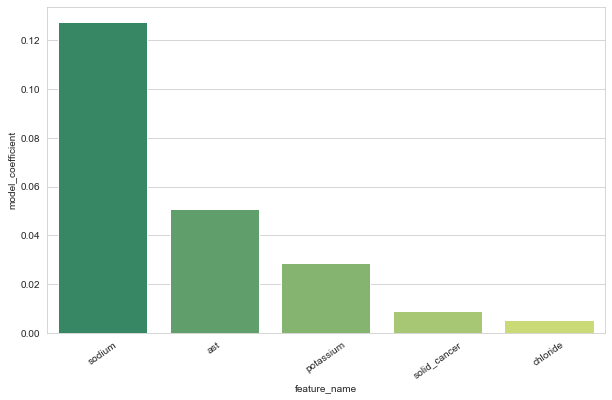

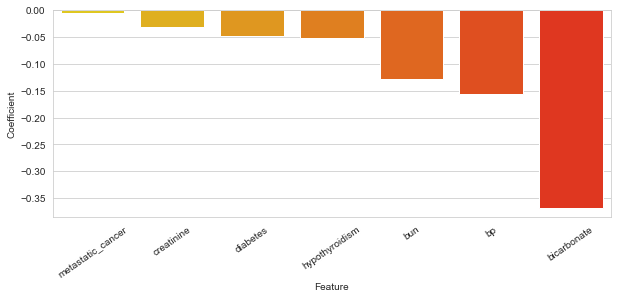

In [75]:
print("Importance of features for hj23 after CV") 
feature_importances_ = coefs_componentes[scores.iloc[0].name]
# Get the models coefficients (and top 5 and bottom 5)
logReg_coeff_pls_hj23 = pd.DataFrame({'feature_name': x_pls.columns.values, 'model_coefficient': feature_importances_.transpose().flatten()})
logReg_coeff_pls_hj23 = logReg_coeff_pls_hj23.sort_values('model_coefficient',ascending=False)
logReg_coeff_top = logReg_coeff_pls_hj23.head(sum(logReg_coeff_pls_hj23['model_coefficient']>0))
logReg_coeff_bottom = logReg_coeff_pls_hj23.tail(sum(logReg_coeff_pls_hj23['model_coefficient']<0))


# Plot top 5 coefficients
plt.figure().set_size_inches(10, 6)
fg3 = sb.barplot(x='feature_name', y='model_coefficient',data=logReg_coeff_top, palette="summer")
fg3.set_xticklabels(rotation=35, labels=logReg_coeff_top.feature_name)
# Plot bottom 5 coefficients
plt.figure().set_size_inches(10,6)
fg4 = sb.barplot(x='feature_name', y='model_coefficient',data=logReg_coeff_bottom, palette="autumn_r")
fg4.set_xticklabels(rotation=35, labels=logReg_coeff_bottom.feature_name)
plt.xlabel('Feature')
plt.ylabel('Coefficient')
plt.subplots_adjust(bottom=0.4)
# plt.savefig('figure_4.png')

In [76]:
logReg_coeff_pls_hj23.to_csv('GeneratedFiles/ImportantVariables/coef_pls_hj23.csv', sep=';', header = False, index=False)